# Objective
In this notebook, we explore various patterns which exist in the data in order to get some insights.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# from py_translator import Translator
import matplotlib.pyplot as plt
import seaborn as sns
import Levenshtein as lev
from sklearn.cluster.bicluster import SpectralBiclustering
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
print(os.listdir("../input/competitive-data-science-predict-future-sales"))
# print(os.listdir('../input/glove-global-vectors-for-word-representation'))
# Any results you write to the current directory are saved as output.

['itemnamesinenglish', 'competitive-data-science-predict-future-sales']
['items.csv', 'sample_submission.csv', 'test.csv', 'sales_train.csv', 'item_categories.csv', 'shops.csv']


In [2]:
COMPETITION_DATA_DIRECTORY = '../input/competitive-data-science-predict-future-sales/'
SALES_FPATH = COMPETITION_DATA_DIRECTORY + 'sales_train.csv'
ITEMS_FPATH = COMPETITION_DATA_DIRECTORY + 'items.csv'
SHOPS_FPATH = COMPETITION_DATA_DIRECTORY + 'shops.csv'
TEST_SALES_FPATH = COMPETITION_DATA_DIRECTORY + 'test.csv'
ITEM_CATEGORIES_FPATH = COMPETITION_DATA_DIRECTORY + 'item_categories.csv'


In [3]:
sales = pd.read_csv(SALES_FPATH)
items = pd.read_csv(ITEMS_FPATH)
shops = pd.read_csv(SHOPS_FPATH)
categ = pd.read_csv(ITEM_CATEGORIES_FPATH)
test = pd.read_csv(TEST_SALES_FPATH)

In [4]:
def date_preprocessing(sales_df):
    if 'date_f' not in sales_df:
        sales_df['date_f'] = pd.to_datetime(sales_df.date, format='%d.%m.%Y')
        sales_df['month'] = sales_df.date_f.apply(lambda x: x.month)
        sales_df['year'] = sales_df.date_f.apply(lambda x: x.year)


def basic_preprocessing(sales_df):
    date_preprocessing(sales_df)
    sales_df.sort_values(['shop_id', 'item_id', 'date_f'], inplace=True)

    if 'shop_item_group' not in sales_df:
        shop_id_changed = sales_df.shop_id.diff() != 0
        item_id_changed = sales_df.item_id.diff() != 0
        ids_changed = shop_id_changed | item_id_changed
        sales_df['shop_item_group'] = ids_changed.cumsum()

basic_preprocessing(sales)

In [5]:
print('sales shape', sales.shape)
print('items shape', items.shape)
print('categories shape', categ.shape)
print('shops shape', shops.shape)
print('')
print('')
print('Num days', len(sales.date.unique()))

sales shape (2935849, 10)
items shape (22170, 3)
categories shape (84, 2)
shops shape (60, 2)


Num days 1034


In [6]:
counts = sales.groupby(['item_id'])['item_price'].count()
print('Item coming in the training only once', 100* round((counts == 1).sum() / counts.shape[0],2))
print('Item coming in the training (0,10]', 100* round(((counts <= 10) &(counts >0)).sum() / counts.shape[0],2))
print('Item coming in the training (10,20]', 100* round(((counts <= 20) &(counts >10)).sum() / counts.shape[0],2))
print('Item coming in the training (20,30]', 100* round(((counts <= 30) &(counts >20)).sum() / counts.shape[0],2))
print('Item coming in the training (30,100]', 100* round(((counts <= 100) &(counts >30)).sum() / counts.shape[0],2))
print('Item coming in the training (100,~)', 100* round((counts >100).sum() / counts.shape[0],2))

Item coming in the training only once 11.0
Item coming in the training (0,10] 31.0
Item coming in the training (10,20] 11.0
Item coming in the training (20,30] 7.000000000000001
Item coming in the training (30,100] 23.0
Item coming in the training (100,~) 28.000000000000004


## Distribution of price

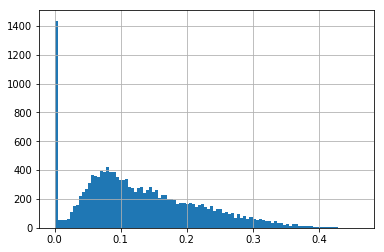

In [7]:
price_max = sales.groupby(['item_id'])['item_price'].max()
price_std = sales.groupby(['item_id'])['item_price'].std()/price_max
price_std = price_std.loc[counts[counts >=10].index]
price_std.hist(bins=100)

In [8]:
print('-ve priced examples', (sales['item_price'] < 0).sum())
print('> 10K priced examples', '{}K'.format((sales['item_price'] > 10_000).sum()/1000))
print('< 10K priced examples', '{}K'.format((sales['item_price'] < 10_000).sum()/1000))

-ve priced examples 1
> 10K priced examples 19.745K
< 10K priced examples 2916.104K


In [9]:
print('Non-price deviating ==>', round((price_std == 0).sum()/price_std.shape[0] * 100, 2))
print('0< Deviation < 0.1 ==>', round(((price_std > 0) & (price_std < 0.1)).sum()/price_std.shape[0] * 100, 2))
print('0.1< Deviation < 0.2 ==>', round(((price_std > 0.1) & (price_std < 0.2)).sum()/price_std.shape[0] * 100, 2))
print('0.2< Deviation < 0.3 ==>', round(((price_std > 0.2) & (price_std < 0.3)).sum()/price_std.shape[0] * 100, 2))

Non-price deviating ==> 8.59
0< Deviation < 0.1 ==> 35.75
0.1< Deviation < 0.2 ==> 34.48
0.2< Deviation < 0.3 ==> 16.85


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


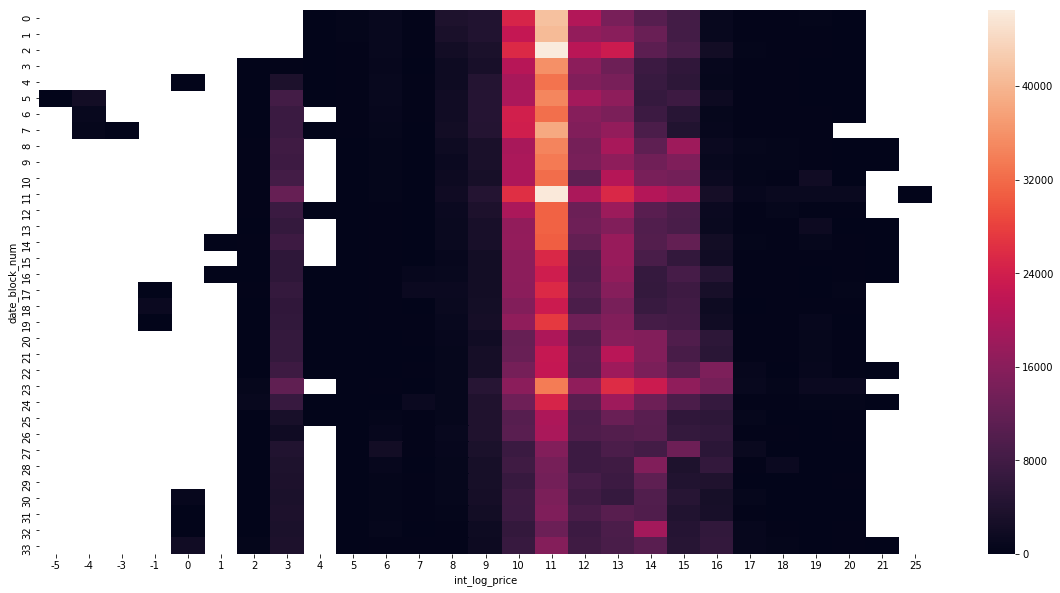

In [10]:
_,ax = plt.subplots(figsize=(20,10))
sales['log_price'] = np.log(sales['item_price'])
sales['int_log_price'] = (2 * sales['log_price'].fillna(0)).astype(int)
_ = sns.heatmap(sales.groupby(['date_block_num','int_log_price'])['item_cnt_day'].sum().unstack(), ax=ax)

**There is some information in changing price as we see that price is changing and is not constant for all times.**

## Analysis on presence of (shop_id,item_id) in train/test data

Text(0.5, 1.0, 'item_id vs shop_id on train data')

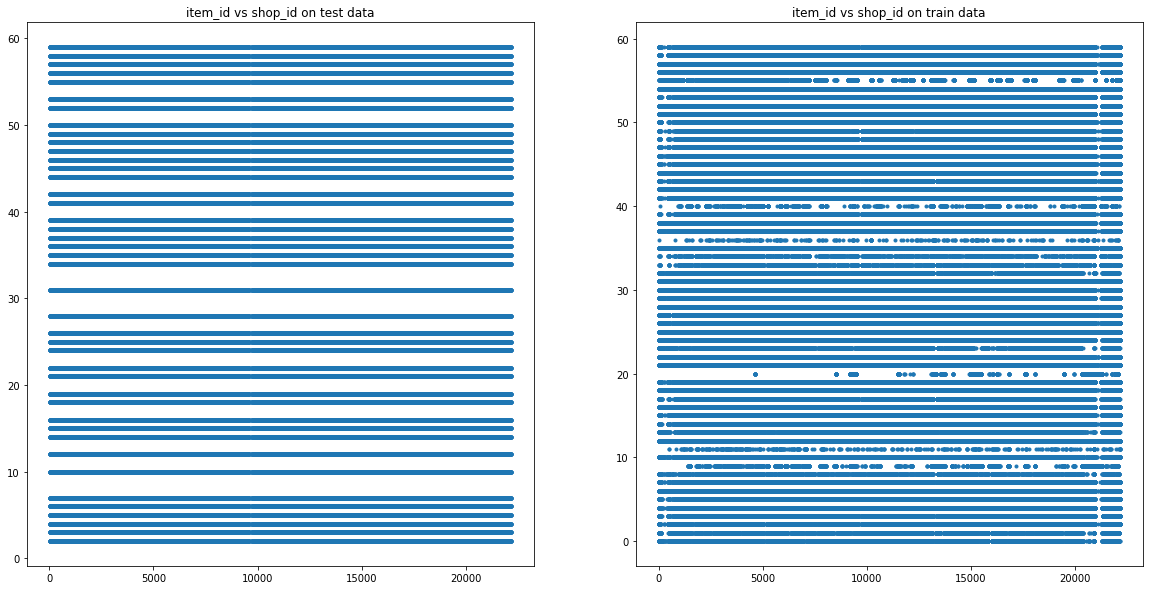

In [11]:
_, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(test['item_id'], test['shop_id'], '.')
ax[0].set_title('item_id vs shop_id on test data')
ax[1].plot(sales['item_id'],sales['shop_id'], '.')
ax[1].set_title('item_id vs shop_id on train data')

In [12]:
print('Number of extra items in test set which are not present in train set', len(set(test['item_id'].unique()) - set(sales['item_id'].unique())))

Number of extra items in test set which are not present in train set 363


**This means we need to handle new item_ids for which we don't have any data in train**

In [13]:
print('No new shops come in test', set(test['shop_id'].unique()) - set(sales['shop_id'].unique()))

No new shops come in test set()


In [14]:
print('Train has some extra shops', set(sales['shop_id'].unique()) - set(test['shop_id'].unique()))

Train has some extra shops {0, 1, 32, 33, 8, 9, 40, 11, 43, 13, 17, 51, 20, 54, 23, 27, 29, 30}


In [15]:
print('Test has a total of following number of items:', len(test.item_id.unique()))

Test has a total of following number of items: 5100


## Hypothesis is that there are a bunch of items which are not traded for some time but they still are given in test.

Text(0.5, 1.0, 'Histogram of for how long has an item not traded for all items in test data. -10 is for new items')

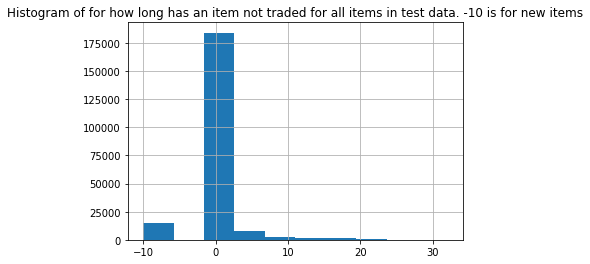

In [16]:
months_not_traded = 33 - sales.groupby('item_id')['date_block_num'].max()
t = test.join(months_not_traded.to_frame('months_not_traded'), on='item_id', how='left').fillna(-10)
assert t.index.equals(test.index)
_, ax= plt.subplots()
t['months_not_traded'].hist(ax=ax)
ax.set_title('Histogram of for how long has an item not traded for all items in test data. -10 is for new items')

### Same analysis is done now with (item_id,shop_id) as id

In [17]:
sales['item_shop_id'] = sales['item_id']*100 + sales['shop_id']
test['item_shop_id'] = test['item_id']*100 + test['shop_id']
months_not_traded_itemshopid = 33 - sales.groupby('item_shop_id')['date_block_num'].max()

Text(0.5, 1.0, 'Histogram of for how long has an item not traded in a particular shop for all (item_id,shop_id) in test data. -10 is for new (item_id,shop_id) entries')

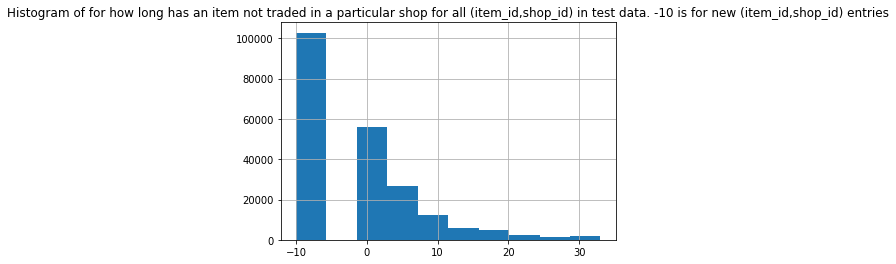

In [18]:
t = test.join(months_not_traded_itemshopid.to_frame('months_not_traded'), on='item_shop_id', how='left').fillna(-10)
assert t.index.equals(test.index)
_, ax = plt.subplots()
t['months_not_traded'].hist(ax=ax)
ax.set_title('Histogram of for how long has an item not traded in a particular shop for all (item_id,shop_id) in test data. -10 is for new (item_id,shop_id) entries')

**One can see that there are some item ids which have not been sold for more than 3 months. For them we can safely assume that they did not trade. Last traded should therefore be included as a feature **

## Checking whether months_not_traded has similar distribution in train and test.

In [19]:
monthly_sales = sales.groupby(['item_id','shop_id','date_block_num']).agg({'item_cnt_day': 'sum'}).reset_index()
def shop_monthly_sales_wrt_months_not_traded(val_df, val_date_block_num, grp_id='item_id'):    
    val_df = val_df.groupby(list(set(['item_id','shop_id','date_block_num']).union({grp_id}))).count().reset_index()

    months_not_traded_val = val_date_block_num -1 - monthly_sales[monthly_sales.date_block_num <val_date_block_num].groupby(grp_id)['date_block_num'].max()
    val_df = val_df.join(months_not_traded_val.to_frame('months_not_traded'), on=grp_id, how='left').fillna(-10)
    return val_df.groupby('months_not_traded')['item_cnt_day'].count()

Text(0.5, 1.0, 'Histogram of for how long has an item not traded for all items in test data and one month train data for various date_block_num')

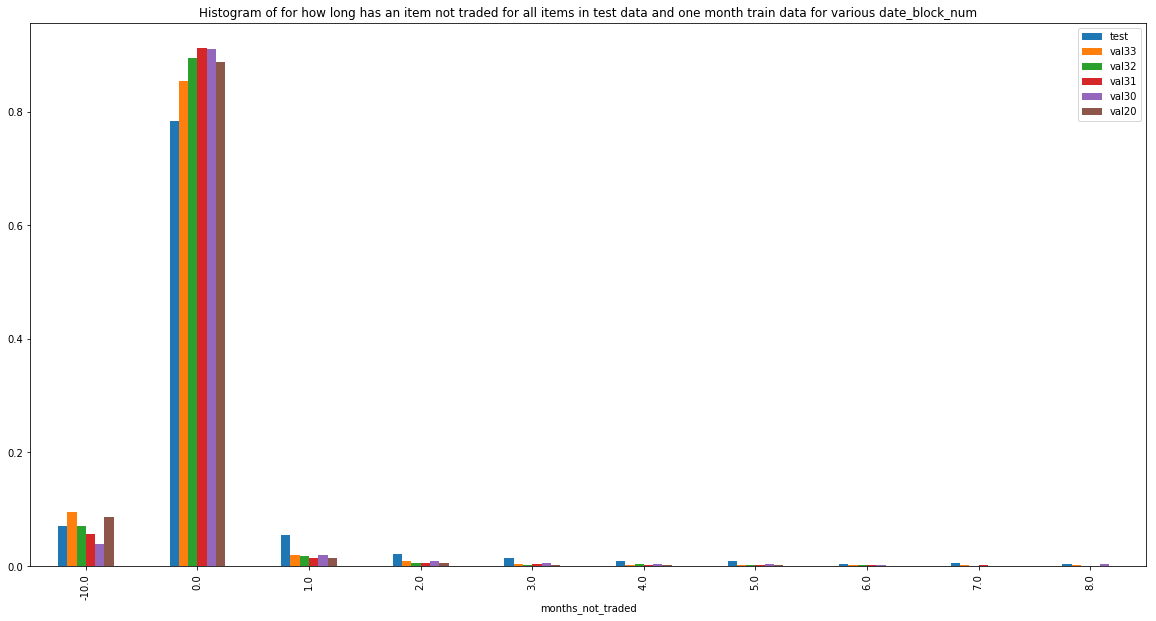

In [20]:
test['date_block_num']=34
test['item_cnt_day'] = 0 
test_dist = shop_monthly_sales_wrt_months_not_traded(test, 34).to_frame('test')
test_dist=test_dist/test_dist['test'].sum()

val33_dist =shop_monthly_sales_wrt_months_not_traded(sales[sales.date_block_num==33], 33).to_frame('val33')
val33_dist=val33_dist/val33_dist['val33'].sum()

val32_dist =shop_monthly_sales_wrt_months_not_traded(sales[sales.date_block_num==32], 32).to_frame('val32')
val32_dist=val32_dist/val32_dist['val32'].sum()

val31_dist =shop_monthly_sales_wrt_months_not_traded(sales[sales.date_block_num==31], 31).to_frame('val31')
val31_dist=val31_dist/val31_dist['val31'].sum()

val30_dist =shop_monthly_sales_wrt_months_not_traded(sales[sales.date_block_num==30], 30).to_frame('val30')
val30_dist=val30_dist/val30_dist['val30'].sum()

val20_dist =shop_monthly_sales_wrt_months_not_traded(sales[sales.date_block_num==20], 20).to_frame('val20')
val20_dist=val20_dist/val20_dist['val20'].sum()

_,ax= plt.subplots(figsize=(20,10))
pd.concat([test_dist,val33_dist,val32_dist,val31_dist,val30_dist,val20_dist],axis=1).iloc[:10].plot.bar(ax=ax)
ax.set_title('Histogram of for how long has an item not traded for all items in test data and one month train data for various date_block_num')


Text(0.5, 1.0, 'Histogram of for how long has an item not traded in a particular shop for all (item_id,shop_id) in test data and one month train data for various date_block_num')

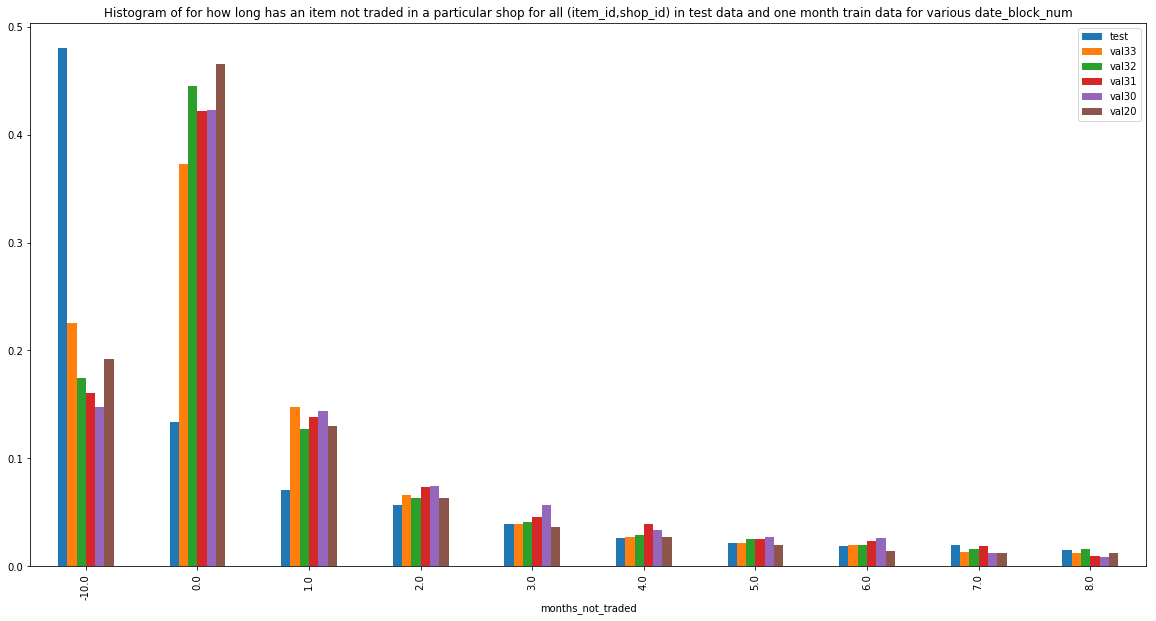

In [21]:
test['date_block_num']=34
test['item_shop_id'] = test['item_id']*100 + test['shop_id']
monthly_sales['item_shop_id'] = monthly_sales['item_id']*100 + monthly_sales['shop_id']

test_dist = shop_monthly_sales_wrt_months_not_traded(test, 34, grp_id='item_shop_id').to_frame('test')
test_dist=test_dist/test_dist['test'].sum()

val33_dist =shop_monthly_sales_wrt_months_not_traded(sales[sales.date_block_num==33], 33, grp_id='item_shop_id').to_frame('val33')
val33_dist=val33_dist/val33_dist['val33'].sum()

val32_dist =shop_monthly_sales_wrt_months_not_traded(sales[sales.date_block_num==32], 32, grp_id='item_shop_id').to_frame('val32')
val32_dist=val32_dist/val32_dist['val32'].sum()

val31_dist =shop_monthly_sales_wrt_months_not_traded(sales[sales.date_block_num==31], 31, grp_id='item_shop_id').to_frame('val31')
val31_dist=val31_dist/val31_dist['val31'].sum()

val30_dist =shop_monthly_sales_wrt_months_not_traded(sales[sales.date_block_num==30], 30, grp_id='item_shop_id').to_frame('val30')
val30_dist=val30_dist/val30_dist['val30'].sum()

val20_dist =shop_monthly_sales_wrt_months_not_traded(sales[sales.date_block_num==20], 20, grp_id='item_shop_id').to_frame('val20')
val20_dist=val20_dist/val20_dist['val20'].sum()

_,ax= plt.subplots(figsize=(20,10))
pd.concat([test_dist,val33_dist,val32_dist,val31_dist,val30_dist,val20_dist],axis=1).iloc[:10].plot.bar(ax=ax)
ax.set_title('Histogram of for how long has an item not traded in a particular shop for all (item_id,shop_id) in test data and one month train data for various date_block_num')

It is evident that a for loop over item_id shop_id has been created. it is so because one can see the enormous amount of -10 entries, ie, entries where shop_id was never seen with that item_id. It can be said as in plot with x being months_not_traded wrt to item_id, -10 entries were similar. This means that number of new items introduced in month 34 is about the same as what gets introduced every month.

In [22]:
def monthly_sales_wrt_months_not_traded_old_items(val_df, dbn,grp_id='item_shop_id'):
    first_month_items = sales.groupby('item_id')['date_block_num'].min()
    new_items = first_month_items[first_month_items == dbn].index.tolist()
    
    first_month_shops = sales.groupby('shop_id')['date_block_num'].min()
    new_shops = first_month_shops[first_month_shops == dbn].index.tolist()
    print('New shops', new_shops )
    val_old_df = val_df[~val_df.item_id.isin(new_items)]
    val_old_df = val_old_df[~val_old_df.shop_id.isin(new_shops)]
    print(val_old_df.shop_id.isin(new_shops).any(),val_old_df.item_id.isin(new_items).any())
    return shop_monthly_sales_wrt_months_not_traded(val_old_df, dbn, grp_id=grp_id)

New shops []
False False


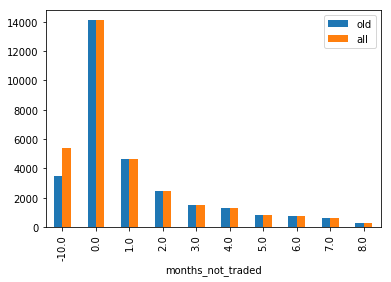

In [23]:
old_val33 = monthly_sales_wrt_months_not_traded_old_items(sales[sales.date_block_num ==31], 31).to_frame('old')
val_33 = shop_monthly_sales_wrt_months_not_traded(sales[sales.date_block_num ==31], 31, grp_id='item_shop_id').to_frame('all')
pd.concat([old_val33, val_33],axis=1).iloc[:10].plot.bar()

**Oldness has much scope for more features.**

1. item oldness
2. item_shop oldness. 
3. shop_category oldness

Last traded has much scope 
1. item last traded.
2. item shop last traded.
3. category last traded.
4. shop category last traded.

In [24]:
test1 = pd.merge(test, items, how='left',on='item_id')

In [25]:
test1['shop_category_id'] = test1['shop_id']*100 + test1['item_category_id']

In [26]:
monthly_sales = sales.groupby(['date_block_num','item_id','shop_id'])['item_cnt_day'].sum().reset_index()
monthly_sales = pd.merge(monthly_sales, items,on='item_id',how='left')

In [27]:
monthly_sales['shop_category_id'] = monthly_sales['shop_id']*100 + monthly_sales['item_category_id']

In [28]:
len(set(test1['shop_category_id'].unique()) - set(monthly_sales['shop_category_id'].unique()))

572

In [29]:
import pandas as pd


def get_unexpected_category_entries_filter(val_df, sales_df, items_df):
    min_dbn = val_df.date_block_num.min()
    sales_df = sales_df[sales_df.date_block_num < min_dbn]
    sales_df = sales_df[sales_df.item_cnt_day > 0]
    if 'item_category_id' not in sales_df:
        sales_df = pd.merge(sales_df, items_df[['item_id', 'item_category_id']], how='left', on='item_id')

    assert 'item_category_id' in val_df

    sales_df['shop_category_id'] = sales_df['shop_id'] * 100 + sales_df['item_category_id']

    assert 'shop_category_id' not in val_df
    val_df['shop_category_id'] = val_df['shop_id'] * 100 + val_df['item_category_id']

    new_item_list = set(val_df.item_id.values) - set(sales_df.item_id.values)
    new_shop_list = set(val_df.shop_id.values) - set(sales_df.shop_id.values)

    old_items_filter = ~val_df.item_id.isin(new_item_list)
    old_shops_filter = ~val_df.shop_id.isin(new_shop_list)
    old_item_shops_filter = old_items_filter & old_shops_filter

    new_shop_category_id_list = set(val_df.shop_category_id.values) - set(sales_df.shop_category_id.values)

    zero_filter = val_df.shop_category_id.isin(new_shop_category_id_list) & old_item_shops_filter

    val_df.drop('shop_category_id', inplace=True, axis=1)
    return zero_filter


In [30]:
monthly_sales = sales.groupby(['item_id','shop_id','date_block_num'])['item_cnt_day'].sum().reset_index()

Text(0.5, 1.0, 'Number of entries for different date_block_num. Red dot is for test data(data_block_num being 34)')

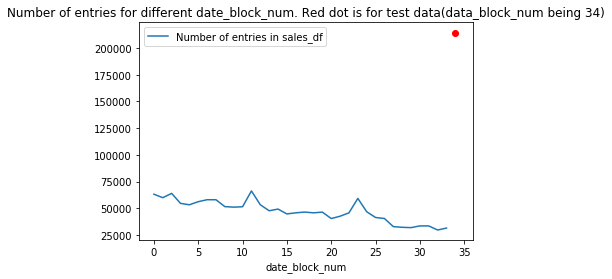

In [31]:
_,ax=plt.subplots()
monthly_sales.groupby('date_block_num')['item_cnt_day'].count().to_frame('Number of entries in sales_df').plot(ax=ax)
ax.scatter([34],[test.shape[0]],c='r')
ax.set_title('Number of entries for different date_block_num. Red dot is for test data(data_block_num being 34)')

**Test has way more entries per month. About 8 times more than what is present in recent months. What this means is that about 7/8th of all entries are zero. One thing to note here is that given this, it is surprising that the months not traded plot of test is more or less similar to differnt months**

## months_not_traded analysis for (shop_id,item_category_id) tuple as id.

In [32]:
if 'item_category_id' not in monthly_sales:
    monthly_sales = pd.merge(monthly_sales,items, on='item_id',how='left')
if 'item_category_id' not in test:
    test = pd.merge(test,items, on='item_id',how='left')


In [33]:
monthly_sales['shop_category_id'] = monthly_sales['shop_id']*100 + monthly_sales['item_category_id']
test['shop_category_id'] = test['shop_id']*100 + test['item_category_id']

Text(0.5, 1.0, 'Histogram of for how long has any item for a given category not traded in a particular shop for all (item_category_id,shop_id) in test data and one month train data for various date_block_num')

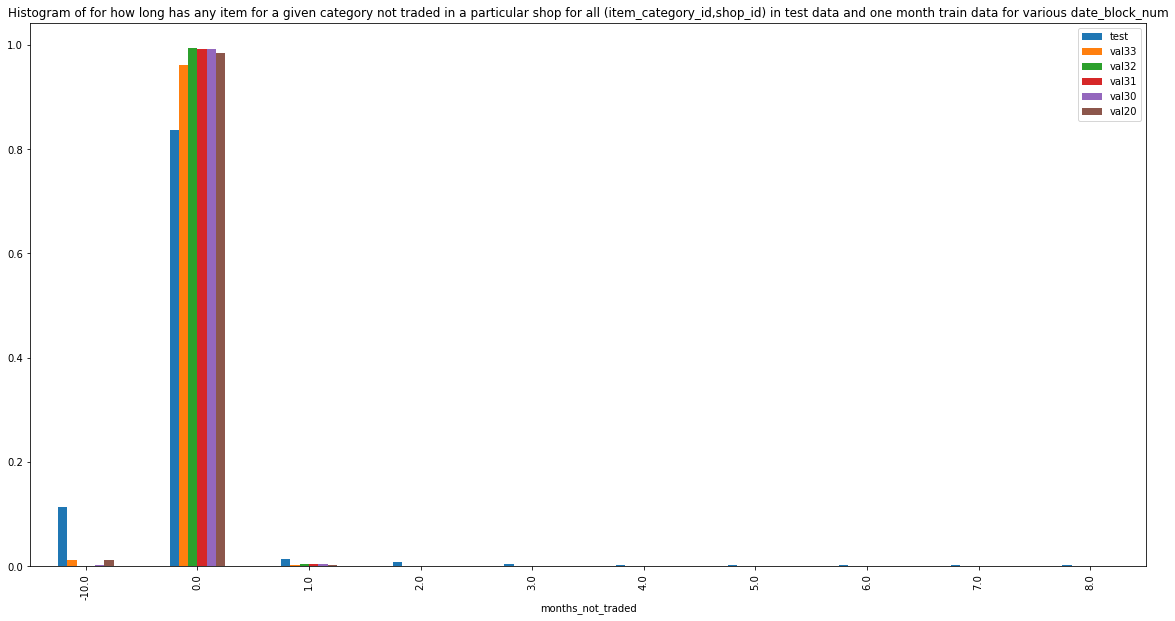

In [34]:
test_dist = shop_monthly_sales_wrt_months_not_traded(test, 34, grp_id='shop_category_id').to_frame('test')
test_dist=test_dist/test_dist['test'].sum()

val33_dist =shop_monthly_sales_wrt_months_not_traded(monthly_sales[monthly_sales.date_block_num==33], 33, grp_id='shop_category_id').to_frame('val33')
val33_dist=val33_dist/val33_dist['val33'].sum()

val32_dist =shop_monthly_sales_wrt_months_not_traded(monthly_sales[monthly_sales.date_block_num==32], 32, grp_id='shop_category_id').to_frame('val32')
val32_dist=val32_dist/val32_dist['val32'].sum()

val31_dist =shop_monthly_sales_wrt_months_not_traded(monthly_sales[monthly_sales.date_block_num==31], 31, grp_id='shop_category_id').to_frame('val31')
val31_dist=val31_dist/val31_dist['val31'].sum()

val30_dist =shop_monthly_sales_wrt_months_not_traded(monthly_sales[monthly_sales.date_block_num==30], 30, grp_id='shop_category_id').to_frame('val30')
val30_dist=val30_dist/val30_dist['val30'].sum()

val20_dist =shop_monthly_sales_wrt_months_not_traded(monthly_sales[monthly_sales.date_block_num==20], 20, grp_id='shop_category_id').to_frame('val20')
val20_dist=val20_dist/val20_dist['val20'].sum()

_,ax= plt.subplots(figsize=(20,10))
pd.concat([test_dist,val33_dist,val32_dist,val31_dist,val30_dist,val20_dist],axis=1).iloc[:10].plot.bar(ax=ax)
ax.set_title('Histogram of for how long has any item for a given category not traded in a particular shop for all (item_category_id,shop_id) in test data and one month train data for various date_block_num')

New shops []
False False
New shops [36]
False False
New shops []
False False
New shops []
False False
New shops []
False False
New shops []
False False


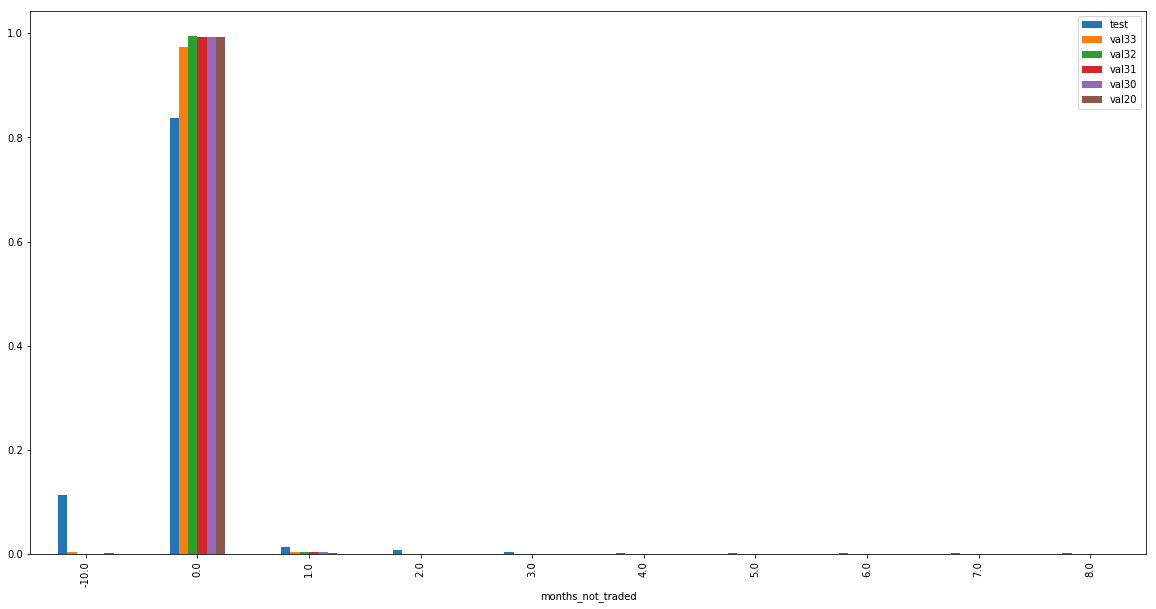

In [35]:
test_dist = monthly_sales_wrt_months_not_traded_old_items(test, 34, grp_id='shop_category_id').to_frame('test')
test_dist=test_dist/test_dist['test'].sum()

val33_dist =monthly_sales_wrt_months_not_traded_old_items(monthly_sales[monthly_sales.date_block_num==33], 33, grp_id='shop_category_id').to_frame('val33')
val33_dist=val33_dist/val33_dist['val33'].sum()

val32_dist =monthly_sales_wrt_months_not_traded_old_items(monthly_sales[monthly_sales.date_block_num==32], 32, grp_id='shop_category_id').to_frame('val32')
val32_dist=val32_dist/val32_dist['val32'].sum()

val31_dist =monthly_sales_wrt_months_not_traded_old_items(monthly_sales[monthly_sales.date_block_num==31], 31, grp_id='shop_category_id').to_frame('val31')
val31_dist=val31_dist/val31_dist['val31'].sum()

val30_dist =monthly_sales_wrt_months_not_traded_old_items(monthly_sales[monthly_sales.date_block_num==30], 30, grp_id='shop_category_id').to_frame('val30')
val30_dist=val30_dist/val30_dist['val30'].sum()

val20_dist =monthly_sales_wrt_months_not_traded_old_items(monthly_sales[monthly_sales.date_block_num==20], 20, grp_id='shop_category_id').to_frame('val20')
val20_dist=val20_dist/val20_dist['val20'].sum()

_,ax= plt.subplots(figsize=(20,10))
pd.concat([test_dist,val33_dist,val32_dist,val31_dist,val30_dist,val20_dist],axis=1).iloc[:10].plot.bar(ax=ax)


**We know that for (shop_id,category_id), sales  is most probably zero if this pair has not been traded.** it is so because we donot see such pairs in training data.

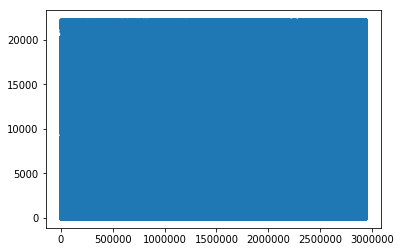

In [36]:
plt.plot(sales['item_id'], '.')

In [37]:
len(set(sales[sales.date_block_num==33].item_id.unique()) - set(test.item_id.unique()))

1422

In [38]:
len(set(test.item_id.unique()) - set(sales[sales.date_block_num >=20].item_id.unique()))

432

In [39]:
extra_item_ids = list(set(test['item_id'].unique()) - set(sales['item_id'].unique()))
extra_item_ids.sort()

In [40]:
category_to_item_df = items.groupby('item_category_id')['item_id'].apply(list)
item_to_category = items.set_index('item_id')['item_category_id']

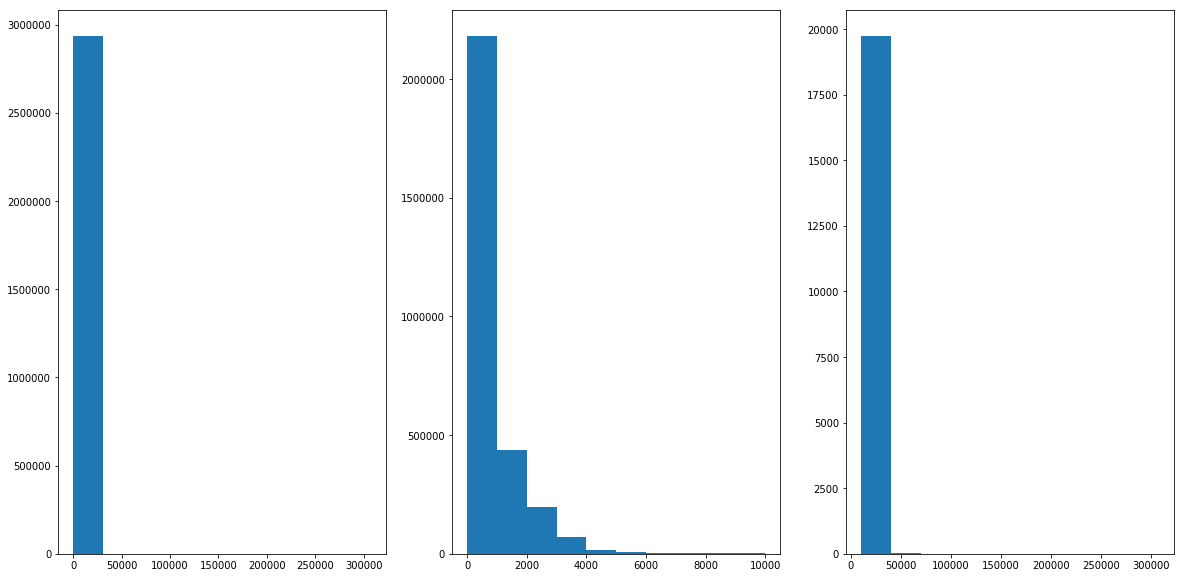

In [41]:
_, ax = plt.subplots(1,3, figsize=(20,10))
_ = ax[0].hist(sales['item_price'])
_ = ax[1].hist(sales[sales['item_price'] < 10_000]['item_price'])
_ = ax[2].hist(sales[sales['item_price'] > 10_000]['item_price'])

In [42]:
print('Number of invalid price entries', np.log(sales['item_price']).isna().sum())

Number of invalid price entries 1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


**We can see some patterns here in the log price. For example, there are some months in which the sales are good. Different price ranges 
have different amount of sales in general**